# **Section4 project 가이드라인**


##Section 4 : Deep Learning 프로젝트의 목적

1. 내가 설정한 포지션에서 적합한 데이터셋 을 구한 뒤 그에 맞는 가설을 세우고 가설을 검증합니다.
2. 가설 검증을 위한 딥러닝 파이프라인을 구축합니다.
3. 구축한 파이프라인은 완벽하지 않아도 되며, 큰 가설의 일부(곁 가지)에 대한 검증을 목표로 해도 좋습니다.
4. 모자란 부분에 대해서는 이후 프로젝트를 통해서 연계해 나가도 좋으며 이런 부분은 '한계점 및 추후 발전 방향' 등을 통해 제시해 주어도 됩니다.

## 프로젝트 설명 index


1. 관심 데이터 선정
2. 데이터 선정 이유
3. 데이터를 이용한 가설 수립
4. 데이터 전처리
5. 딥러닝 방식 적용
6. Chance Level이 넘는지 확인
7. 모델검증
8. (Option) Requirements.txt 제작 및 재구현

## 프로젝트 채점기준
1. "여러분이 풀고자 하는 문제를 잘 설정하였는가?"
2. "문제를 풀기 위한 모델 선택을 알맞게 설정하였는가?"
3. "모델 학습을 제대로 진행하였는가?"
4. "완성하지 못한 부분에 대하여 "한계점과 추후 해결 방안을 알맞게 작성하였는가?"
5. "영상 길이는 5분 이상 10분 이내로 작성합니다
. 너무 길어지거나 너무 짧아지지 않도록 해주세요!"

# "FIRE DETECTION"

### 프로젝트 설명
* 대학교때 했던 화재 감지 데이터를 가지고 이번 섹션에서 했던 모델과 캐글에 있는 코드를 분석하여 하나하나 주석을 쓰며 어떠한 코드 인지 분석하고 코드를 수정하면서 개선해 나가려는 목적

[kaggle FIRE DATASET](https://www.kaggle.com/datasets/phylake1337/fire-dataset) -> fire_dataset

fire_dataset에서 fire 이미지 1859개 추가 nonfire 1978개 추가 -> fire_dataset1

#### 1. 데이터 선정 이유
+ CCTV를 실시간으로 확인을 할 수가 없기 때문에 인공지능을 통해서 빠르게 탐지하여 알림을 한다.
+ 현재 있는 스모크를 이용한 화재용 소화 스프링클러는 감지 알림의 오작동과 스프링클러 오작동의 확률이 높다.
+ 화재(fire)과 비화재(non_fire)의 이진 분류

#### 2. 데이터를 이용한 가설 수립
1) 빨간색의 사진은 화재일 가능성이 있는가?

2) 국소적인 (작은) 화재를 정확도가 높게 판단할수 있는가?

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-02-07 06:46:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-07 06:46:04 (72.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
BATCH_SIZE = 32 # 배치사이즈 를 정해놓기
IMAGE_SIZE = (320, 320) # 이미지 사이즈 고정

In [5]:
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브 마운트

Mounted at /content/drive


In [30]:
import os
dataset = "/content/drive/MyDrive/fire_dataset" # fire_dataset1 or fire_dataset 

In [31]:
walk_through_dir(dataset) # helper_functions.py 의 walk_through_dir를 통해서 path안에 있는 이미지 확인

There are 2 directories and 0 images in '/content/drive/MyDrive/fire_dataset'.
There are 0 directories and 244 images in '/content/drive/MyDrive/fire_dataset/non_fire_images'.
There are 0 directories and 755 images in '/content/drive/MyDrive/fire_dataset/fire_images'.


In [32]:
image_dir = Path(dataset)

# Get filepaths and labels # jpg와 png 리스트로 가져오기
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) # non_fire_images와 fire_images로 라벨링
filepaths = pd.Series(filepaths, name='Filepath').astype(str) # 파일 경로 
labels = pd.Series(labels, name='Label') # non

# Concatenate filepaths and labels # 데이터 프레임으로 만들기
image_df = pd.concat([filepaths, labels], axis=1)

In [33]:
len(list(image_dir.glob(r'**/*.png')))

999

In [34]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
1,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
2,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
3,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
4,/content/drive/MyDrive/fire_dataset/non_fire_i...,non_fire_images
...,...,...
994,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images
995,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images
996,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images
997,/content/drive/MyDrive/fire_dataset/fire_image...,fire_images


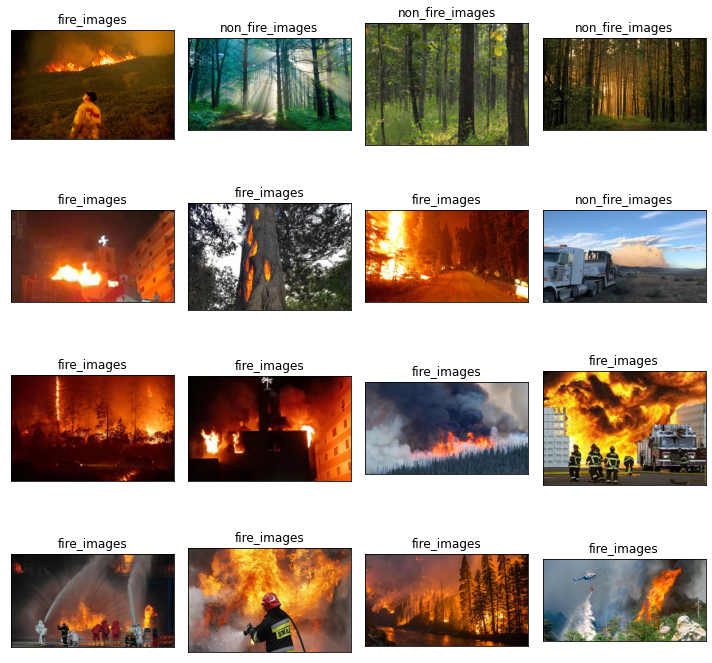

In [35]:
import matplotlib.image as mpimg
# 16개의 임의의 이미지를 라벨링과 함께 출력
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

**1) 빨간색의 사진은 화재일 가능성이 있는가?**

가능성이 있을 수도 있음 non_fire_images에서도 불과 관련된 색이나 다른모양이 있어서 가능성이 있다

**2) 국소적인 (작은) 화재를 정확도가 높게 판단할수 있는가?**

fire_images에도 비화재 관련 이미지의 부분이 많기 때문에 화재가 아니게 판단할 수 있다. 

작은 화재의 관련해서는 feedback에서 생각해보자.

### 데이터 나누기
ImageDataGenerator를 이용 

In [36]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [37]:
# mobilenet_v2 의 generator 사용
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [38]:
# train val test 나누기
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [39]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# 3. Training the model

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (320, 320, 3)

**Output layer** : 1

In [40]:
# 사전 훈련된 MobileNetV2 모델 가져오기
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [41]:
# callback을 위한 체크포인트
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [42]:
# 3epochs 동안 val_loss가 높아지지 않을때 EarlyStopping callback 설정 
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [43]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20230207-073154
Epoch 1/100
20/20 [==============================] - 204s 10s/step - loss: 0.3867 - accuracy: 0.8125 - val_loss: 0.2014 - val_accuracy: 0.9434
Epoch 2/100
20/20 [==============================] - 24s 1s/step - loss: 0.1629 - accuracy: 0.9484 - val_loss: 0.1377 - val_accuracy: 0.9560
Epoch 3/100
20/20 [==============================] - 24s 1s/step - loss: 0.1063 - accuracy: 0.9672 - val_loss: 0.1077 - val_accuracy: 0.9560
Epoch 4/100
20/20 [==============================] - 24s 1s/step - loss: 0.0757 - accuracy: 0.9812 - val_loss: 0.0942 - val_accuracy: 0.9623
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 0.0587 - accuracy: 0.9828 - val_loss: 0.0990 - val_accuracy: 0.9623
Epoch 6/100
20/20 [==============================] - 24s 1s/step - loss: 0.0505 - accuracy: 0.9781 - val_loss: 0.0830 - val_accuracy: 0.9686
Epoch 7/100
20/20 [==============================] - 23s 1s/step - lo

# Model Evaluation

**Precision(P)**:

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 

<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 

<center>$F1=2 * (TP * FP)/(TP+FP)$</center>

In [44]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.03401
Test Accuracy: 99.50%


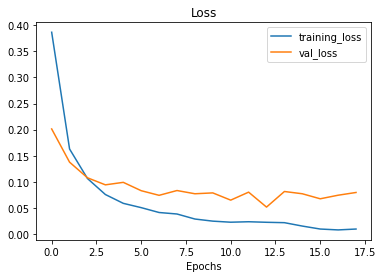

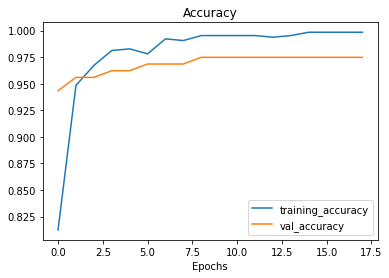

In [45]:
plot_loss_curves(history)

## 4. 모델 평가

In [47]:
# 테스트 이미지의 레이블 예측
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 6s 1s/step
The first 5 predictions: ['fire_images', 'fire_images', 'non_fire_images', 'fire_images', 'fire_images']


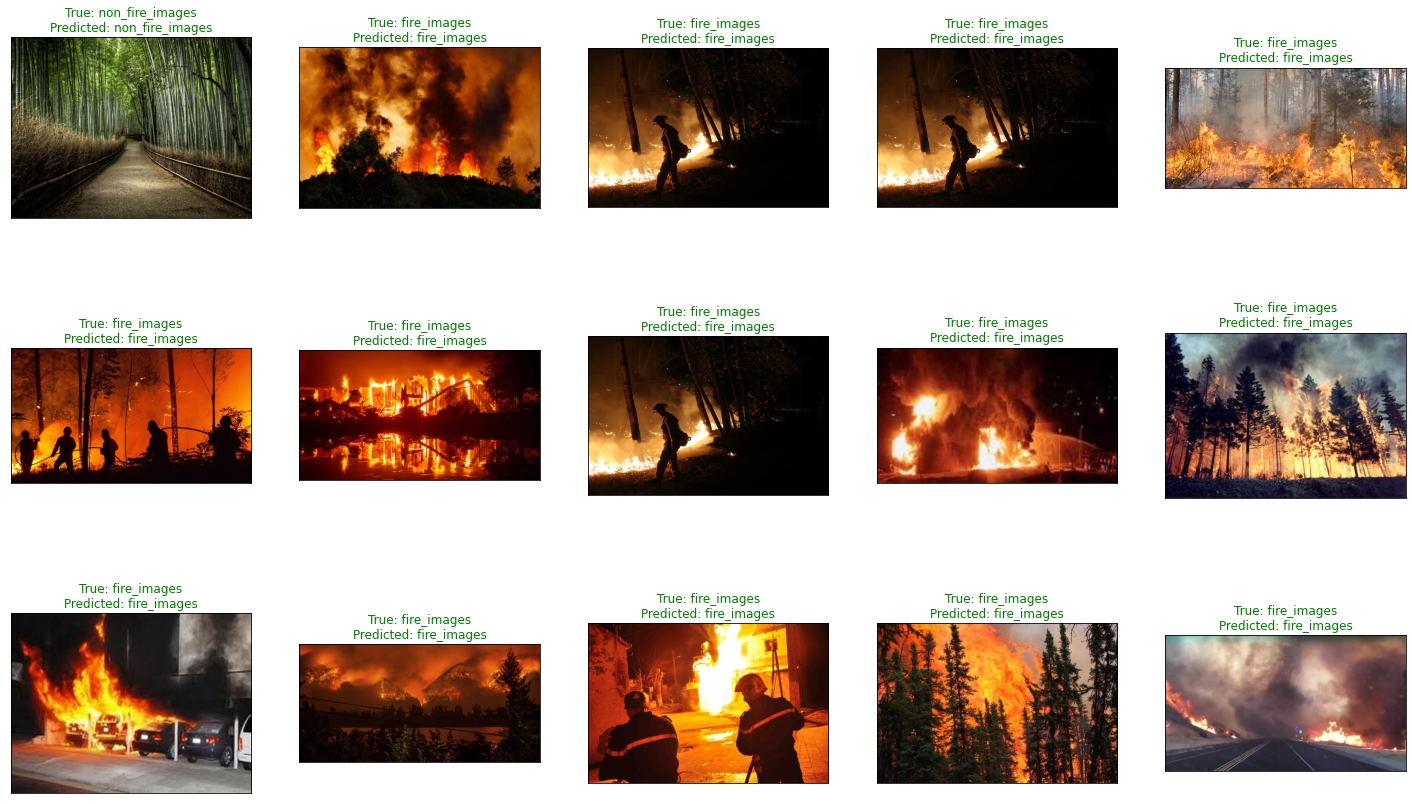

<Figure size 432x288 with 0 Axes>

In [49]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green" # 맞으면 초록색
    else:
      color = "red" # 틀리면 빨간색
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [50]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.99      1.00      1.00       158
non_fire_images       1.00      0.98      0.99        42

       accuracy                           0.99       200
      macro avg       1.00      0.99      0.99       200
   weighted avg       1.00      0.99      0.99       200



In [51]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire_images,0.993711,1.000000,0.996845,158.000
non_fire_images,1.000000,0.976190,0.987952,42.000
accuracy,0.995000,0.995000,0.995000,0.995
macro avg,0.996855,0.988095,0.992399,200.000
weighted avg,0.995031,0.995000,0.994978,200.000


저번에 대학교에서도 이렇게 사전훈련된 모델을 가지고 훈련을 해서 화재 이미지를 예측 했는데 시도 해보지 않은 모델을 가지고 해보는 것이 재미 있었습니다.

캐글 노트북에서 거의 따왔지만 이미지 변경과 이 노트북에 관해서 코드를 검색해가며 설명을 주석으로 쓰면서 공부하는 것이 재미 있었습니다. 

화재 이미지 같은경우 가설에서 말했듯이 이미지 안의 국소적인 화재 때문에 object detection을 통해서 사각형 박스를 통해서 예측하는게 좀 더 정확합니다. 그래서 추가적으로 다른 여러가지 모델을 적용시키는 것과 yolo를 통해서 object detection을 하는 방법을 해볼 예정 입니다.